<a href="https://colab.research.google.com/github/snanduri94/RecessionForecasting/blob/main/Recession_Forecasting_with_FRED_data_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fredapi
!pip install fred-py-api

In [ ]:
import pandas as pd
import numpy as np
from fredapi import Fred
import yfinance as yf
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
fred = Fred(api_key="67050bf5d7df507388ee5c6bf1e9e08c")

In [ ]:
# Define the series codes for each of the variables
series_codes = {
    'NBER Recession Indicator': 'USREC',
    'AAA Yields': 'AAA',
    'BAA Yields': 'BAA',
    'Business Loans': 'BUSLOANS',
    '10 Year Govt Bond Yields': 'GS10',
    '3M Treasury Yields': 'GS3M',
    'Single Family Housing Permits': 'PERMIT',
    'Yield Curve': 'T10Y2Y',
    'Real Personal Consumption Expenditures': 'PCE',
    'Consumer Sentiment': 'UMCSENT',
    'Total Business Inventories to Sales Ratio': 'ISRATIO',
    'Corporate Profits After Tax': 'CP',
    'Housing Starts': 'HOUST',
    'Effective Federal Funds Rate': 'FEDFUNDS'
}

start_date = datetime.datetime(1970, 1, 1)
end_date = datetime.datetime.today()

In [ ]:
# Fetch data from FRED and store in a dataframe
dataframes = []
for description, code in series_codes.items():
    series = fred.get_series(code, start_date, end_date)
    series.name = description
    dataframes.append(series)

# Fetch Initial Unemployment Claims, resample to monthly and add to dataframes list
unemployment_claims = fred.get_series('IC4WSA', start_date, end_date)
unemployment_claims_monthly = unemployment_claims.resample('M').sum()
unemployment_claims_monthly.name = 'Initial Unemployment Claims'
dataframes.append(unemployment_claims_monthly)

# Fetch S&P 500 monthly data from Yahoo Finance
spx_data = yf.download('^GSPC', start=start_date, end=end_date, progress=False, interval="1mo")
spx_monthly_pct_change = spx_data['Close'].pct_change().dropna()  # Calculate monthly percentage change
spx_monthly_pct_change.name = 'SPX Monthly Pct Change'
dataframes.append(spx_monthly_pct_change)

In [ ]:
# Combine all series into one dataframe
df = pd.concat(dataframes, axis=1)

# Handle missing values (you can adjust this as per your model's requirement)
df.fillna(method='ffill', inplace=True)  # Forward fill to handle missing values
df.fillna(method='bfill', inplace=True)  # Backward fill for any remaining missing values
df_month_end = df.resample('M').last()
# Display the dataframe
df_month_end.head()

,NBER Recession Indicator,AAA Yields,BAA Yields,Business Loans,10 Year Govt Bond Yields,3M Treasury Yields,Single Family Housing Permits,Yield Curve,Real Personal Consumption Expenditures,Consumer Sentiment,Total Business Inventories to Sales Ratio,Corporate Profits After Tax,Housing Starts,Effective Federal Funds Rate,Initial Unemployment Claims,SPX Monthly Pct Change
1970-01-31,1.0,7.91,8.86,106.2979,7.79,15.61,1062.0,0.68,628.7,78.1,1.56,55.323,1085.0,8.98,1199500.0,0.008629
1970-02-28,1.0,7.93,8.78,105.6953,7.24,15.61,1118.0,0.68,634.0,78.1,1.56,55.323,1305.0,8.98,1025000.0,0.008629
1970-03-31,1.0,7.84,8.63,105.4128,7.07,15.61,1132.0,0.68,632.3,78.1,1.56,55.323,1319.0,7.76,1049500.0,0.008629
1970-04-30,1.0,7.83,8.70,105.6766,7.39,15.61,1224.0,0.68,636.0,78.1,1.56,55.194,1264.0,8.10,1182750.0,0.008629
1970-05-31,1.0,8.11,8.98,106.0118,7.91,15.61,1328.0,0.68,642.4,75.4,1.56,55.194,1290.0,7.95,1627500.0,0.008629


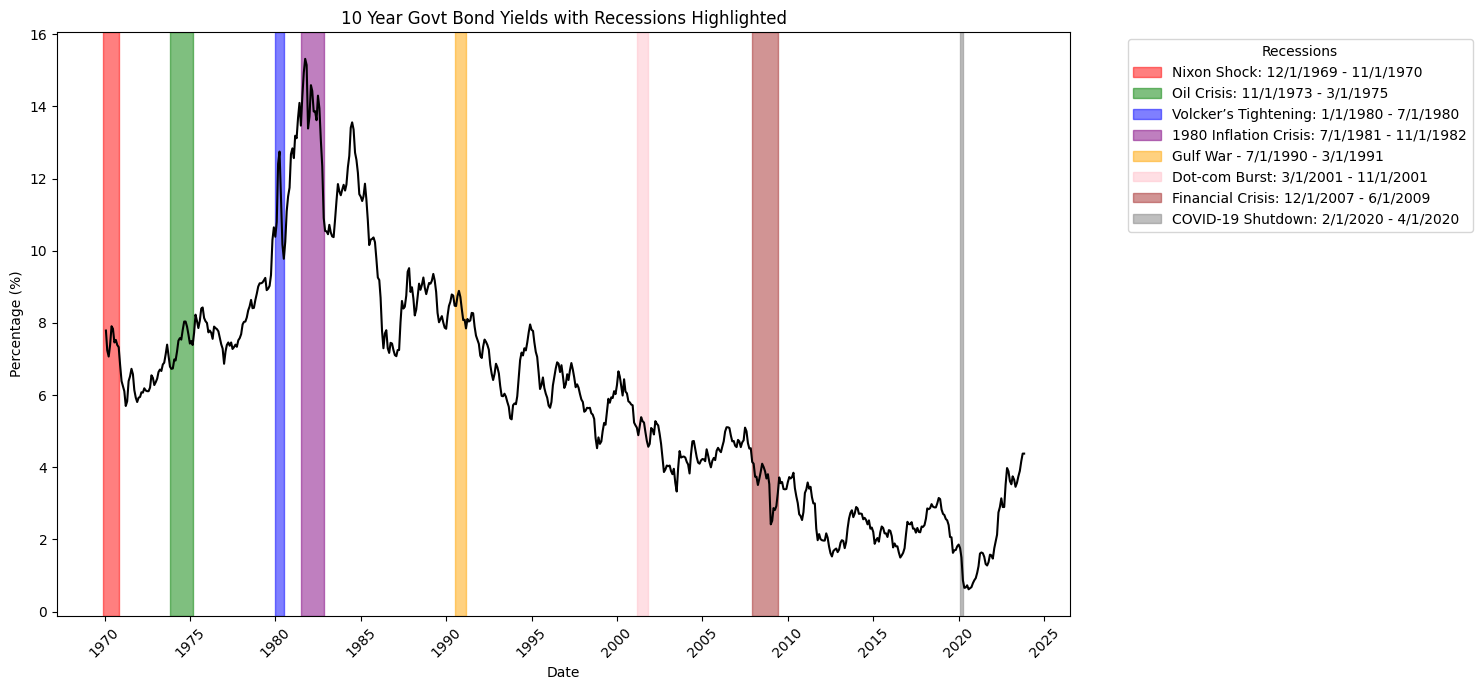

In [ ]:
# Plotting the 10 Year Govt Bond Yields with Recessions Highlighted
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_month_end, x=df_month_end.index, y="10 Year Govt Bond Yields", color='black')
plt.title('10 Year Govt Bond Yields with Recessions Highlighted')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')

# Recessions data with unique colors
recession_periods = [
    (datetime.datetime(1969, 12, 1), datetime.datetime(1970, 11, 1), 'Nixon Shock: 12/1/1969 - 11/1/1970', 'red'),
    (datetime.datetime(1973, 11, 1), datetime.datetime(1975, 3, 1), 'Oil Crisis: 11/1/1973 - 3/1/1975', 'green'),
    (datetime.datetime(1980, 1, 1), datetime.datetime(1980, 7, 1), 'Volcker’s Tightening: 1/1/1980 - 7/1/1980', 'blue'),
    (datetime.datetime(1981, 7, 1), datetime.datetime(1982, 11, 1), '1980 Inflation Crisis: 7/1/1981 - 11/1/1982', 'purple'),
    (datetime.datetime(1990, 7, 1), datetime.datetime(1991, 3, 1), 'Gulf War - 7/1/1990 - 3/1/1991', 'orange'),
    (datetime.datetime(2001, 3, 1), datetime.datetime(2001, 11, 1), 'Dot-com Burst: 3/1/2001 - 11/1/2001', 'pink'),
    (datetime.datetime(2007, 12, 1), datetime.datetime(2009, 6, 1), 'Financial Crisis: 12/1/2007 - 6/1/2009', 'brown'),
    (datetime.datetime(2020, 2, 1), datetime.datetime(2020, 4, 1), 'COVID-19 Shutdown: 2/1/2020 - 4/1/2020', 'gray')
]

# Shading the periods for each recession with unique colors
for start, end, label, color in recession_periods:
    plt.axvspan(start, end, color=color, alpha=0.5, label=label)

# Setting up the legend outside the plot
plt.legend(loc="upper left", title="Recessions", bbox_to_anchor=(1.05, 1))

# Improve formatting of the x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

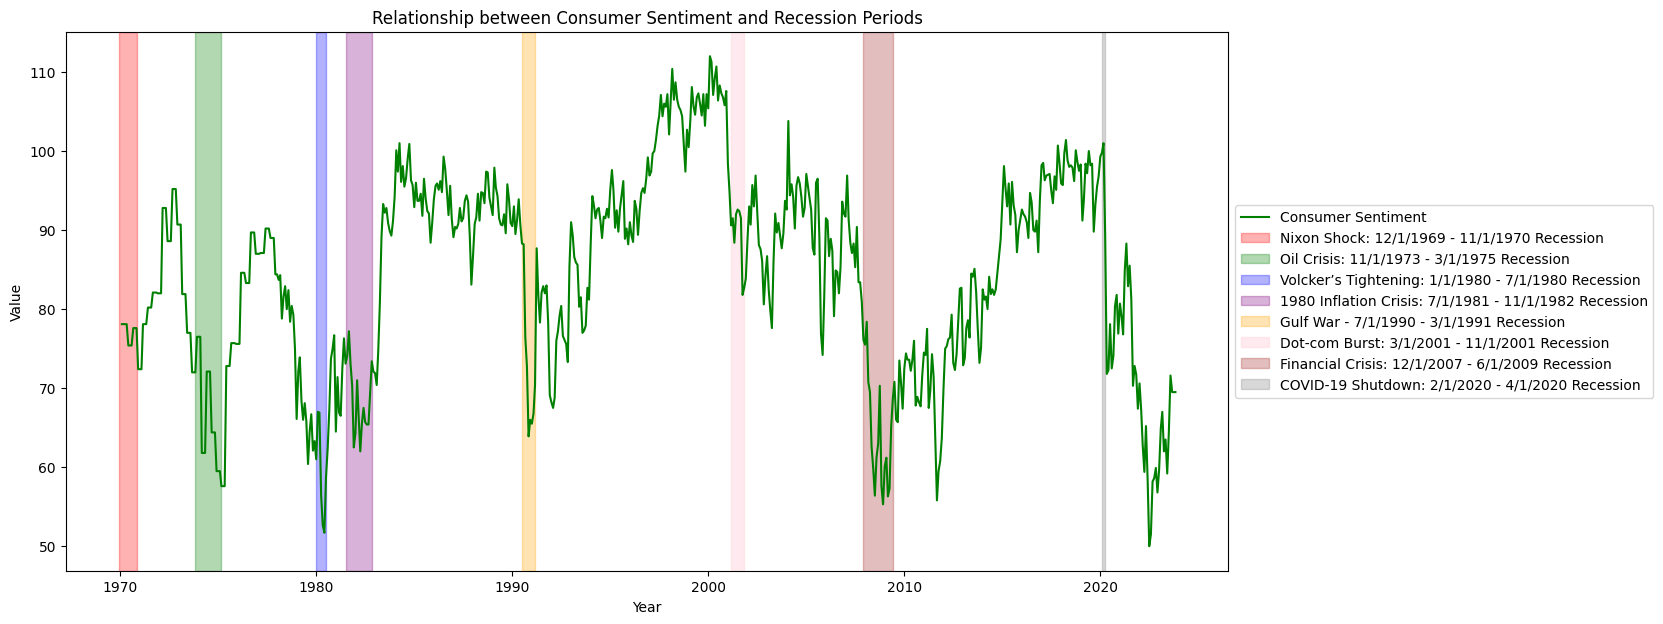

In [ ]:
# Define the economic variables to plot
economic_variables = ['Consumer Sentiment']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 7))

# Plot each economic variable with a unique color and style
colors = ['green', 'orange']
linestyles = ['-', '--', '-.', ':', '-']
for i, variable in enumerate(economic_variables):
    sns.lineplot(data=df_month_end, x=df_month_end.index, y=variable, label=variable, color=colors[i], linestyle=linestyles[i])

# Shade recession periods and add labels
for start, end, name, color in recession_periods:
    ax.axvspan(start, end, color=color, alpha=0.3, label=name + ' Recession')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Value')
plt.title('Relationship between Consumer Sentiment and Recession Periods')

# Display legend outside on the right side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

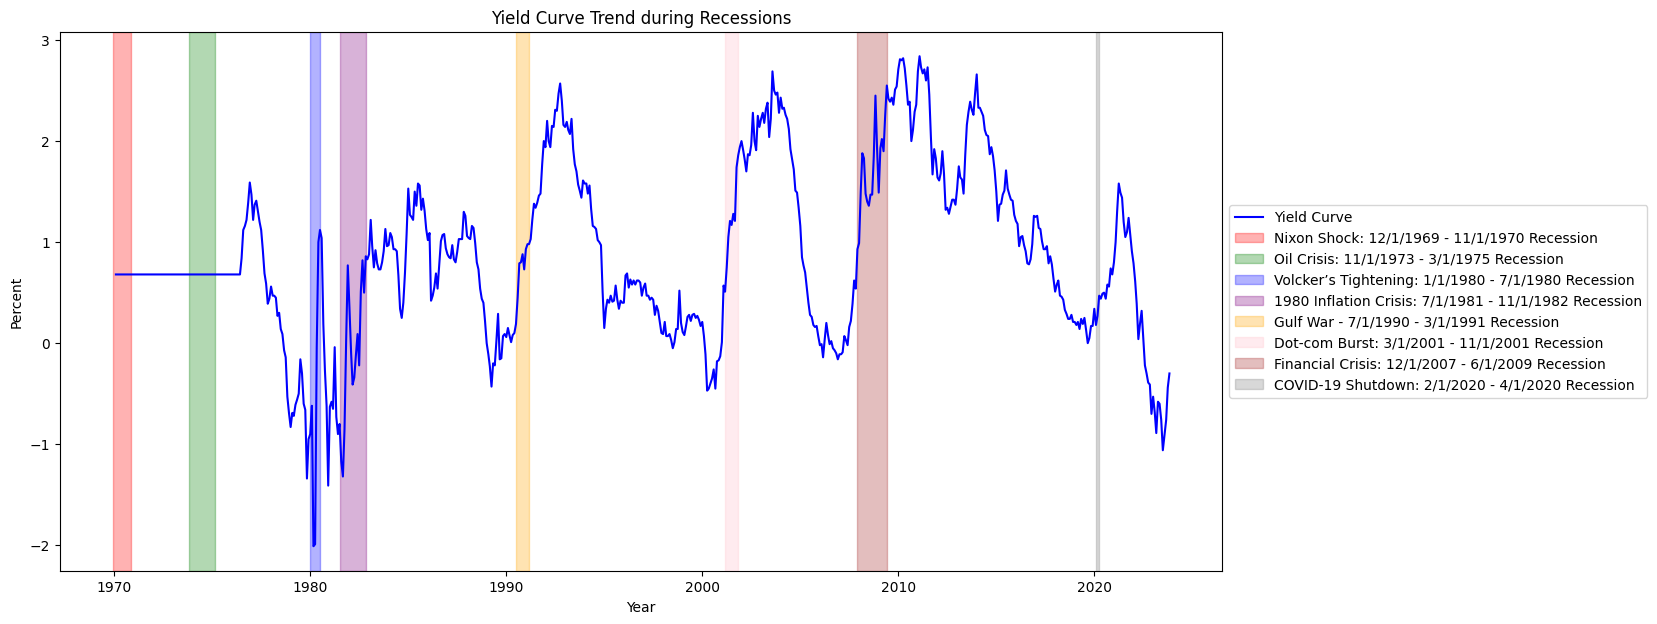

In [ ]:
# Define the economic variables to plot
economic_variables = ['Yield Curve']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 7))

# Plot each economic variable with a unique color and style
colors = ['blue']
linestyles = ['-', '--', '-.', ':', '-']
for i, variable in enumerate(economic_variables):
    sns.lineplot(data=df_month_end, x=df_month_end.index, y=variable, label=variable, color=colors[i], linestyle=linestyles[i])

# Shade recession periods and add labels
for start, end, name, color in recession_periods:
    ax.axvspan(start, end, color=color, alpha=0.3, label=name + ' Recession')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Percent')
plt.title('Yield Curve Trend during Recessions')

# Display legend outside on the right side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [ ]:
# Recessions data with unique colors
recession_periods = [
    (datetime.datetime(1969, 12, 1), datetime.datetime(1970, 11, 1), 'Nixon Shock', 'red'),
    (datetime.datetime(1973, 11, 1), datetime.datetime(1975, 3, 1), 'Oil Crisis', 'green'),
    (datetime.datetime(1980, 1, 1), datetime.datetime(1980, 7, 1), 'Volcker’s Tightening', 'blue'),
    (datetime.datetime(1981, 7, 1), datetime.datetime(1982, 11, 1), '1980 Inflation Crisis', 'purple'),
    (datetime.datetime(1990, 7, 1), datetime.datetime(1991, 3, 1), 'Gulf War', 'orange'),
    (datetime.datetime(2001, 3, 1), datetime.datetime(2001, 11, 1), 'Dot-com Burst', 'pink'),
    (datetime.datetime(2007, 12, 1), datetime.datetime(2009, 6, 1), 'Financial Crisis', 'brown'),
    (datetime.datetime(2020, 2, 1), datetime.datetime(2020, 4, 1), 'COVID-19 Shutdown', 'gray')
]

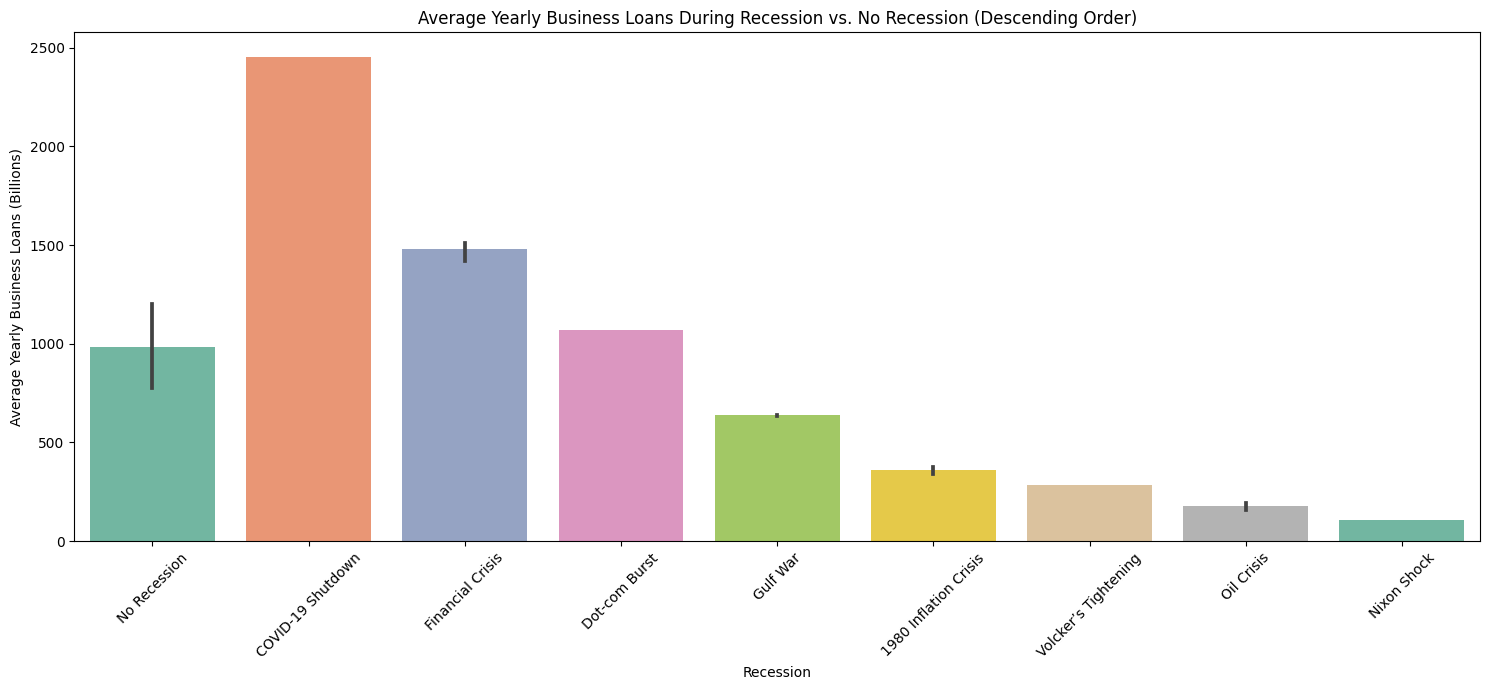

In [ ]:
# Create a DataFrame to hold Business Loans data and recession labels
business_loans_df = df_month_end[['Business Loans']].copy()
business_loans_df['Recession'] = 'No Recession'

# Fill the 'Recession' column with the corresponding label for each recession period
for start, end, label, _ in recession_periods:
    business_loans_df.loc[(business_loans_df.index >= start) & (business_loans_df.index <= end), 'Recession'] = label

# Calculate the average yearly Business Loans for each recession label
average_yearly_loans = business_loans_df.groupby('Recession')['Business Loans'].resample('Y').mean().reset_index()

# Sort the DataFrame in descending order based on average yearly Business Loans
average_yearly_loans = average_yearly_loans.sort_values(by=['Business Loans'], ascending=False)

# Create a bar chart to compare average yearly Business Loans during recession vs. no recession
plt.figure(figsize=(15, 7))
sns.barplot(data=average_yearly_loans, x='Recession', y='Business Loans', palette='Set2')
plt.title('Average Yearly Business Loans During Recession vs. No Recession (Descending Order)')
plt.xlabel('Recession')
plt.ylabel('Average Yearly Business Loans (Billions)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

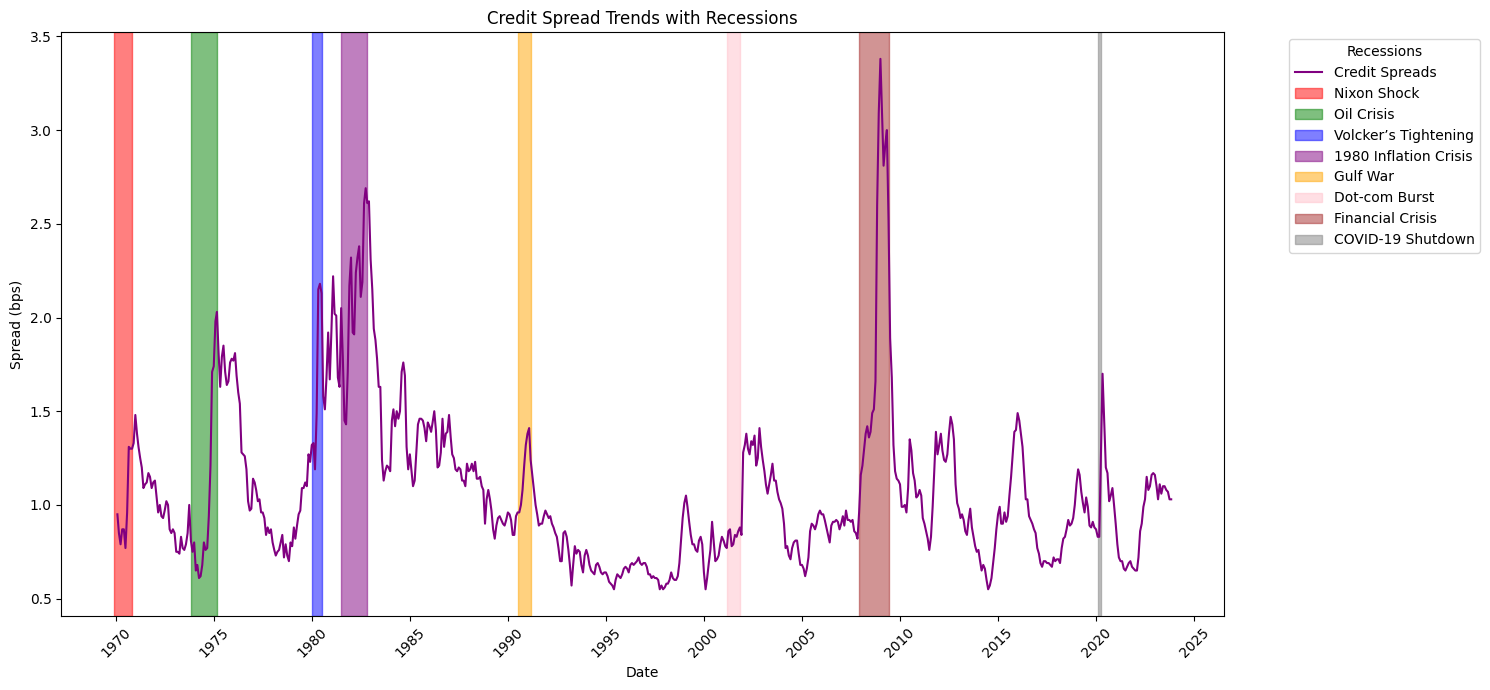

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 7))

# Calculate and plot credit spreads with recessions
df_month_end['Credit Spreads'] = df_month_end['BAA Yields'] - df_month_end['AAA Yields']
ax.plot(df_month_end.index, df_month_end['Credit Spreads'], label='Credit Spreads', color='purple')

# Shade recession periods
for start, end, label, color in recession_periods:
    ax.axvspan(start, end, color=color, alpha=0.5, label=label)

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Spread (bps)')
ax.set_title('Credit Spread Trends with Recessions')
ax.legend(loc="upper left", title="Recessions", bbox_to_anchor=(1.05, 1))

# Format x-axis date labels with 5-year intervals
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [ ]:
df_month_end["NBER Recession Indicator"].sum()/646

0.13157894736842105

In [ ]:
# Define your target variable (y)
y = df_month_end['NBER Recession Indicator']

# Define your feature matrix (X) including all columns except the target variable
X = df_month_end.drop(columns=['NBER Recession Indicator'])

# Step 1: Data Preparation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=654)

# Step 2: Model Building
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 3: Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print(classification_report(y_test, y_pred))

Accuracy: 0.8810572687224669
Confusion Matrix:
 [[194   0]
 [ 27   6]]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       194
         1.0       1.00      0.18      0.31        33

    accuracy                           0.88       227
   macro avg       0.94      0.59      0.62       227
weighted avg       0.90      0.88      0.84       227



In [ ]:
rf_model = RandomForestClassifier(random_state=654)
rf_model.fit(X_train, y_train)

# Step 4: Model Evaluation
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Print evaluation metrics
print("Random Forest Classifier")
print("Accuracy:", accuracy_rf)
print("Confusion Matrix:\n", conf_matrix_rf)
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier
Accuracy: 0.9647577092511013
Confusion Matrix:
 [[192   2]
 [  6  27]]
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       194
         1.0       0.93      0.82      0.87        33

    accuracy                           0.96       227
   macro avg       0.95      0.90      0.93       227
weighted avg       0.96      0.96      0.96       227



In [ ]:
df_month_end.describe()

,NBER Recession Indicator,AAA Yields,BAA Yields,Business Loans,10 Year Govt Bond Yields,3M Treasury Yields,Single Family Housing Permits,Yield Curve,Real Personal Consumption Expenditures,Consumer Sentiment,Total Business Inventories to Sales Ratio,Corporate Profits After Tax,Housing Starts,Effective Federal Funds Rate,Initial Unemployment Claims,SPX Monthly Pct Change,Credit Spreads
count,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,6.460000e+02,646.000000,646.000000
mean,0.131579,7.173034,8.249133,975.582849,6.031935,6.347276,1404.213622,0.857105,6603.635759,84.178793,1.448359,876.208054,1435.791022,4.905944,1.631291e+06,0.008060,1.076099
std,0.338294,2.789856,2.989196,738.180029,3.141967,5.641132,399.236233,0.863471,4866.885675,12.883814,0.111219,831.953525,412.423093,3.919590,9.957135e+05,0.037306,0.429771
min,0.000000,2.140000,3.160000,105.412800,0.620000,0.010000,513.000000,-2.010000,628.700000,50.000000,1.240000,53.350000,478.000000,0.050000,7.937500e+05,-0.217630,0.550000
25%,0.000000,5.092500,6.052500,394.828250,3.537500,1.377500,1130.500000,0.272500,2283.100000,74.325000,1.360000,205.845250,1172.250000,1.422500,1.267812e+06,-0.001231,0.782500
50%,0.000000,7.220000,8.090000,775.320650,5.985000,5.100000,1421.000000,0.680000,5364.900000,87.000000,1.450000,533.362000,1463.000000,4.990000,1.500250e+06,0.008629,0.960000
75%,0.000000,8.787500,9.905000,1360.446625,7.892500,9.427500,1685.500000,1.420000,10204.875000,93.700000,1.560000,1560.780000,1698.000000,6.910000,1.771125e+06,0.024250,1.240000
max,1.000000,15.490000,17.180000,3034.059100,15.320000,15.610000,2419.000000,2.840000,18726.900000,112.000000,1.740000,3148.734000,2494.000000,19.100000,1.873675e+07,0.131767,3.380000


In [ ]:
df_lagged = df_month_end
# Create 6-month lagged predictors
for column in df_month_end.columns:
    if column != 'NBER Recession Indicator':
        df_month_end[f"{column}_lag6"] = df_month_end[column].shift(6)

# Drop rows with NaN values (first 6 rows due to the lag)
df_month_end.dropna(inplace=True)

# Splitting the data into X and y
X = df_month_end.drop('NBER Recession Indicator', axis=1)
y = df_month_end['NBER Recession Indicator']


In [ ]:
# Temporal train-test split
train_size = int(len(X) * 0.70)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Step 3: Train the Model
rf_model = RandomForestClassifier(random_state=654)
rf_model.fit(X_train, y_train)

# Step 4: Model Evaluation
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Print evaluation metrics
print("Random Forest Classifier")
print("Accuracy:", accuracy_rf)
print("Confusion Matrix:\n", conf_matrix_rf)
print(classification_report(y_test, y_pred_rf))


Random Forest Classifier
Accuracy: 0.9114583333333334
Confusion Matrix:
 [[172   0]
 [ 17   3]]
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       172
         1.0       1.00      0.15      0.26        20

    accuracy                           0.91       192
   macro avg       0.96      0.57      0.61       192
weighted avg       0.92      0.91      0.88       192



In [ ]:
from sklearn.model_selection import RandomizedSearchCV


# Random Forest Parameter grid
param_dist = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}


In [ ]:
rf = RandomForestClassifier(random_state=654)

# Random search of parameters
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,
    cv=10,
    verbose=2,
    random_state=654,
    n_jobs=-1
)

# Fit the random search model
rf_random.fit(X_train, y_train)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=654),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200,
                                                         500]},
                   random_state=654, verbose=2)

In [ ]:
print("Best Parameters:", rf_random.best_params_)

Best Parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'class_weight': 'balanced_subsample', 'bootstrap': False}


In [ ]:
best_rf = rf_random.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)

# Print evaluation metrics
print("Random Forest Classifier with Best Parameters")
print("Accuracy:", accuracy_best_rf)
print("Confusion Matrix:\n", conf_matrix_best_rf)
print(classification_report(y_test, y_pred_best_rf))


Random Forest Classifier with Best Parameters
Accuracy: 0.8958333333333334
Confusion Matrix:
 [[172   0]
 [ 20   0]]
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95       172
         1.0       0.00      0.00      0.00        20

    accuracy                           0.90       192
   macro avg       0.45      0.50      0.47       192
weighted avg       0.80      0.90      0.85       192



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Obtain prediction probabilities for the test data
probs = best_rf.predict_proba(X_test)

# Extract the last six probabilities for class 1 (recession)
last_six_probs = probs[-6:, 1]

# Display the last six probabilities
for i, prob in enumerate(last_six_probs, 1):
    print(f"Prediction {i}: Probability of Recession = {prob:.4f}")

Prediction 1: Probability of Recession = 0.0900
Prediction 2: Probability of Recession = 0.0967
Prediction 3: Probability of Recession = 0.0783
Prediction 4: Probability of Recession = 0.0935
Prediction 5: Probability of Recession = 0.0993
Prediction 6: Probability of Recession = 0.0978


In [ ]:
# Using the trained RandomForest model (from earlier, before the custom scorer)
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Displaying the probabilities
print(y_probs)

[0.18 0.22 0.24 0.29 0.32 0.39 0.37 0.32 0.45 0.52 0.45 0.49 0.48 0.51
 0.51 0.47 0.5  0.5  0.46 0.41 0.47 0.44 0.4  0.42 0.43 0.41 0.41 0.38
 0.41 0.39 0.43 0.42 0.45 0.43 0.44 0.41 0.43 0.44 0.39 0.41 0.4  0.41
 0.4  0.42 0.45 0.43 0.45 0.46 0.46 0.42 0.4  0.42 0.41 0.39 0.39 0.4
 0.42 0.41 0.29 0.36 0.31 0.24 0.25 0.25 0.21 0.24 0.24 0.28 0.24 0.28
 0.26 0.23 0.19 0.18 0.27 0.24 0.24 0.17 0.17 0.25 0.21 0.21 0.19 0.18
 0.2  0.2  0.23 0.28 0.29 0.22 0.2  0.24 0.24 0.26 0.28 0.26 0.26 0.27
 0.25 0.29 0.27 0.27 0.26 0.27 0.3  0.28 0.27 0.32 0.28 0.26 0.26 0.29
 0.28 0.26 0.32 0.28 0.31 0.24 0.22 0.21 0.21 0.18 0.2  0.22 0.19 0.21
 0.18 0.15 0.18 0.23 0.21 0.25 0.21 0.28 0.26 0.25 0.25 0.29 0.26 0.31
 0.26 0.24 0.24 0.25 0.33 0.27 0.28 0.3  0.37 0.48 0.35 0.36 0.31 0.34
 0.3  0.26 0.28 0.26 0.26 0.25 0.28 0.3  0.23 0.24 0.28 0.21 0.26 0.26
 0.24 0.21 0.18 0.28 0.28 0.25 0.29 0.3  0.3  0.29 0.3  0.28 0.24 0.28
 0.17 0.08 0.23 0.16 0.21 0.16 0.05 0.08 0.06 0.06]


       Probability of Recession
count                192.000000
mean                   0.297812
std                    0.098281
min                    0.050000
25%                    0.240000
50%                    0.280000
75%                    0.390000
max                    0.520000


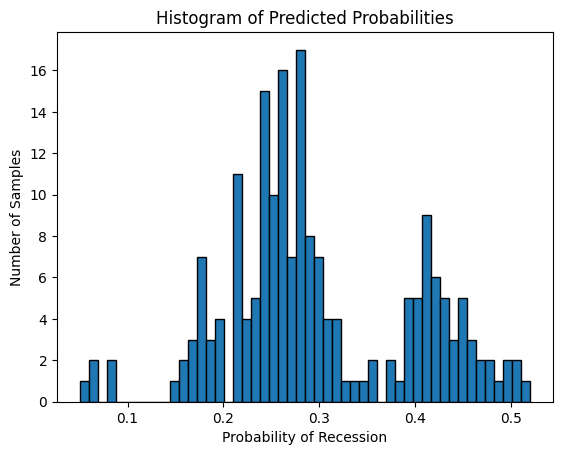

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert probabilities to a DataFrame for easier handling
df_probs = pd.DataFrame(y_probs, columns=["Probability of Recession"])

# Summary statistics
print(df_probs.describe())

# Histogram
plt.hist(df_probs["Probability of Recession"], bins=50, edgecolor='k')
plt.title("Histogram of Predicted Probabilities")
plt.xlabel("Probability of Recession")
plt.ylabel("Number of Samples")
plt.show()

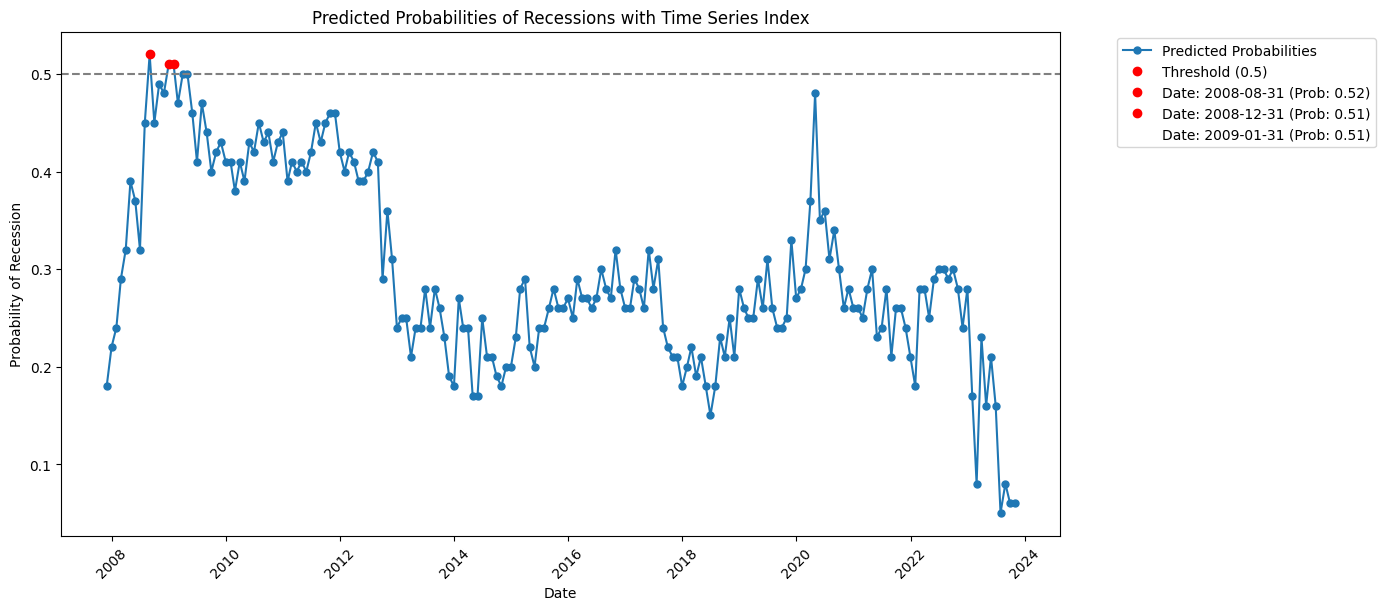

In [ ]:

threshold = 0.50

# Predicted classes
y_pred = (y_probs > threshold).astype(int)
correct_recession_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true == 1 and pred == 1]
correctly_predicted_recessions = X_test.iloc[correct_recession_indices]
import matplotlib.pyplot as plt


# Plotting all the probabilities with time series index
plt.figure(figsize=(14, 6))
plt.plot(X_test.index, y_probs, '-o', label='Predicted Probabilities', markersize=5)

# Highlighting the correctly predicted recessions using the time series index
for index in correctly_predicted_recessions.index:
    plt.plot(index, y_probs[X_test.index.get_loc(index)], 'ro')  # Using red circles to highlight

# Creating a list to hold custom legend entries
legend_entries = ['Predicted Probabilities', f'Threshold ({threshold})']

# Adding dates where probability is above the threshold to the custom legend
above_threshold_dates = X_test.index[y_probs > threshold]
for date in above_threshold_dates:
    prob = y_probs[X_test.index.get_loc(date)]
    label = f"Date: {date.strftime('%Y-%m-%d')} (Prob: {prob:.2f})"
    plt.plot([], [], ' ', label=label)  # Empty plot to add entries to the legend
    legend_entries.append(label)

plt.axhline(threshold, color='grey', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Probability of Recession')
plt.title('Predicted Probabilities of Recessions with Time Series Index')
plt.legend(legend_entries, loc="upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate the date labels for better visibility
plt.show()

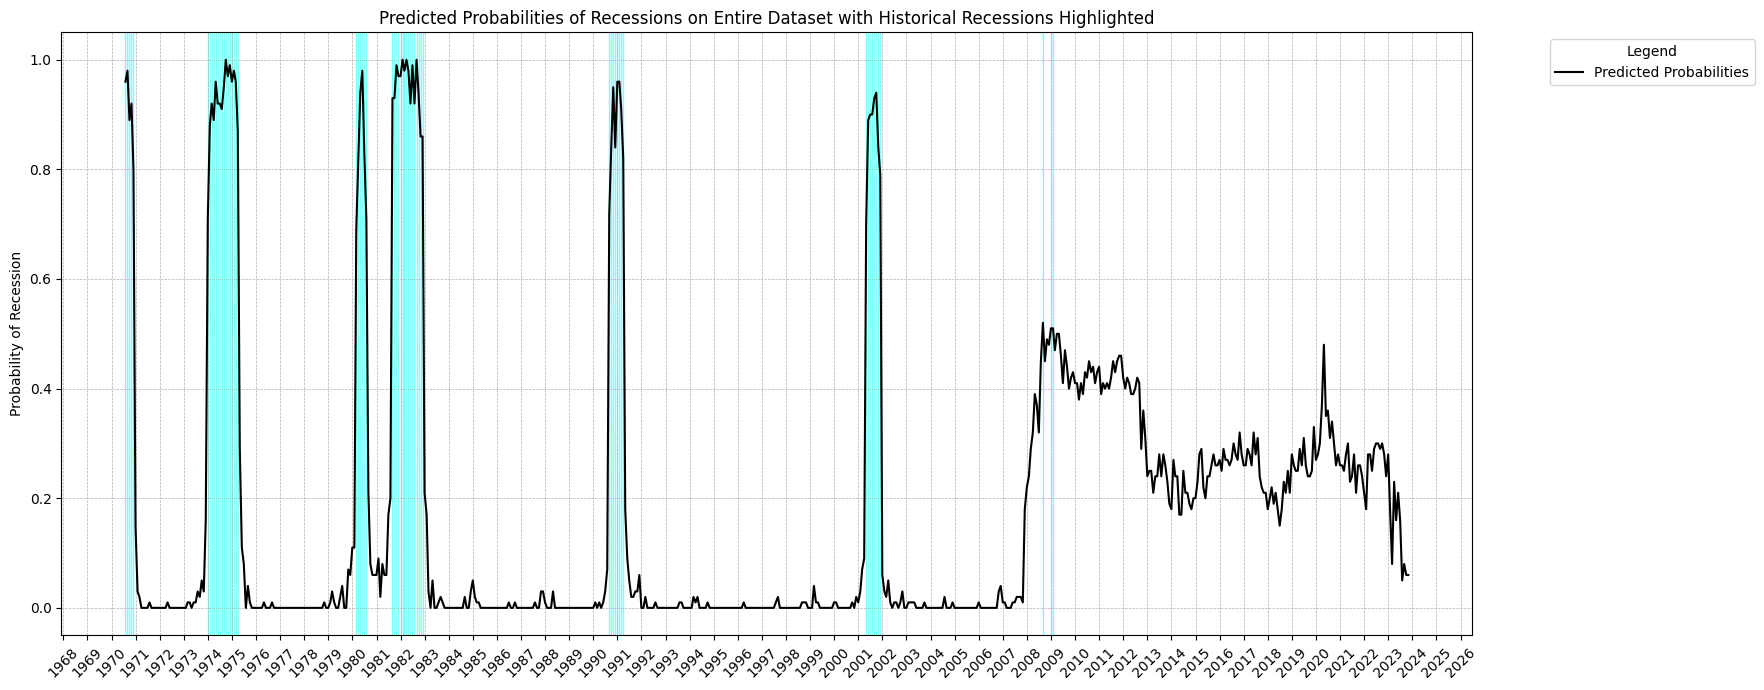

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Predict probabilities for the entire dataset
y_probs_full = rf_model.predict_proba(X)[:, 1]
y_pred_full = (y_probs_full > 0.5).astype(int)

plt.figure(figsize=(15, 7))

# Plotting the Predicted Probabilities
sns.lineplot(x=X.index, y=y_probs_full, color='black', label="Predicted Probabilities")

# Highlight regions where model correctly predicted recessions
correct_recession_indices = X[(y == 1) & (y_pred_full == 1)].index
for start in correct_recession_indices:
    end = start  # As you're using monthly data, this will shade a single month
    plt.axvspan(start, end, color='cyan', alpha=0.5)


# Shading the historical recession periods
#for start, end, label, color in recession_periods:
    #plt.axvspan(start, end, color=color, alpha=0.5, label=label)

# Improve formatting of the x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.ylabel('Probability of Recession')
plt.title('Predicted Probabilities of Recessions on Entire Dataset with Historical Recessions Highlighted')
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc="upper left", title="Legend", bbox_to_anchor=(1.05, 1))

plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Predict the classes for the entire dataset using the threshold of 0.5
y_pred_full = (y_probs_full > 0.7).astype(int)

# Generate and print the classification report
report = classification_report(y, y_pred_full)
print(report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y, y_pred_full)
print(conf_matrix)

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       561
         1.0       1.00      0.72      0.84        79

    accuracy                           0.97       640
   macro avg       0.98      0.86      0.91       640
weighted avg       0.97      0.97      0.96       640

[[561   0]
 [ 22  57]]


In [ ]:
df_lagged = df_month_end
# Create 6-month lagged predictors
for column in df_month_end.columns:
    if column != 'NBER Recession Indicator':
        df_month_end[f"{column}_lag6"] = df_month_end[column].shift(6)

# Drop rows with NaN values (first 6 rows due to the lag)
df_month_end.dropna(inplace=True)

# Splitting the data into X and y
X = df_month_end.drop('NBER Recession Indicator', axis=1)
y = df_month_end['NBER Recession Indicator']


In [ ]:
# Temporal train-test split
train_size = int(len(X) * 0.70)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
import xgboost as xgb
# 3. Define and train the XGBoost classifier
model = xgb.XGBClassifier()

model.fit(X_train, y_train)

# 4. Make predictions
y_pred = model.predict(X_test)

# 5. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(confusion)
print(classification_report(y_test, y_pred))

Accuracy: 0.91005291005291
[[170   0]
 [ 17   2]]
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       170
         1.0       1.00      0.11      0.19        19

    accuracy                           0.91       189
   macro avg       0.95      0.55      0.57       189
weighted avg       0.92      0.91      0.88       189



In [ ]:
# 2. Define the hyperparameter grid for the randomized search
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 2, 5],
    'scale_pos_weight': [1, 2, 5],
}

# 3. Create a randomized search object with cross-validation
random_search = RandomizedSearchCV(
    model, param_distributions=param_grid_xgb, n_iter=10, scoring='accuracy', cv=3, verbose=2, n_jobs=-1
)

# 4. Fit the randomized search to your training data
random_search.fit(X_train, y_train)

# 5. Get the best parameters and best estimator from the search
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# 6. Make predictions using the best model
y_pred = best_model.predict(X_test)

# 7. Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# 8. Print the results
print("Best Parameters:", best_params)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.9, 'scale_pos_weight': 2, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 0.8}
Accuracy: 0.8994708994708994
Confusion Matrix:
[[170   0]
 [ 19   0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95       170
         1.0       0.00      0.00      0.00        19

    accuracy                           0.90       189
   macro avg       0.45      0.50      0.47       189
weighted avg       0.81      0.90      0.85       189



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


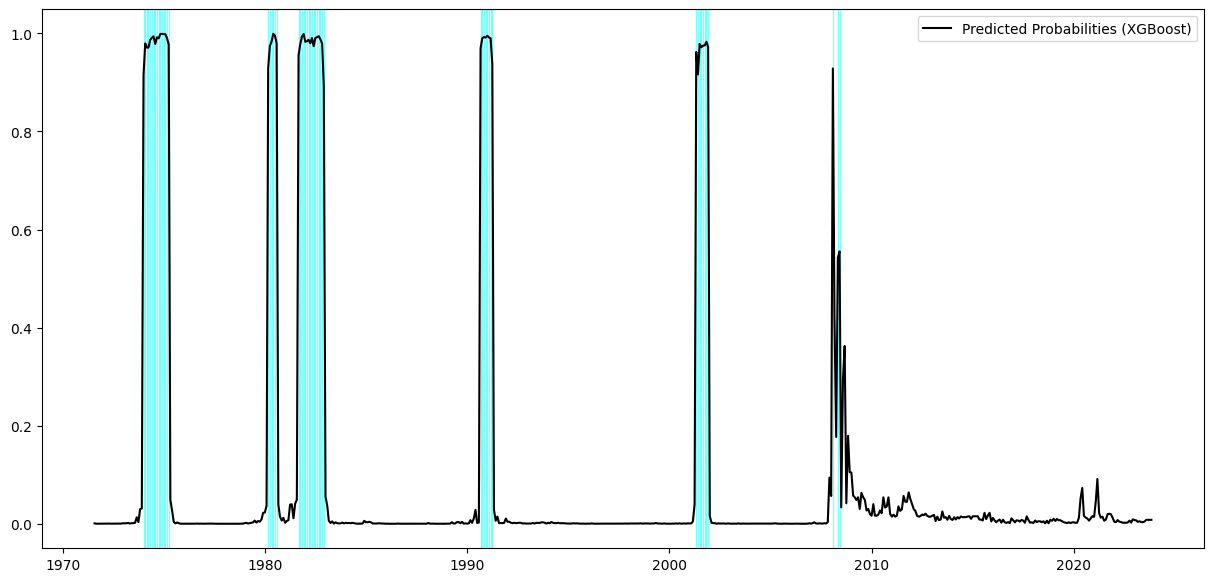

In [ ]:
# Predict probabilities for the entire dataset using XGBoost
y_probs_xgb_full = model.predict_proba(X)[:, 1]
y_pred_xgb_full = (y_probs_xgb_full > 0.5).astype(int)

plt.figure(figsize=(15, 7))

# Plotting the Predicted Probabilities for XGBoost
sns.lineplot(x=X.index, y=y_probs_xgb_full, color='black', label="Predicted Probabilities (XGBoost)")

# Highlight regions where the XGBoost model correctly predicted recessions
correct_recession_indices_xgb = X[(y == 1) & (y_pred_xgb_full == 1)].index
for start in correct_recession_indices_xgb:
    end = start  # As you're using monthly data, this will shade a single month
    plt.axvspan(start, end, color='cyan', alpha=0.5)

In [ ]:
y_probs_xgb_full.shape

(628,)

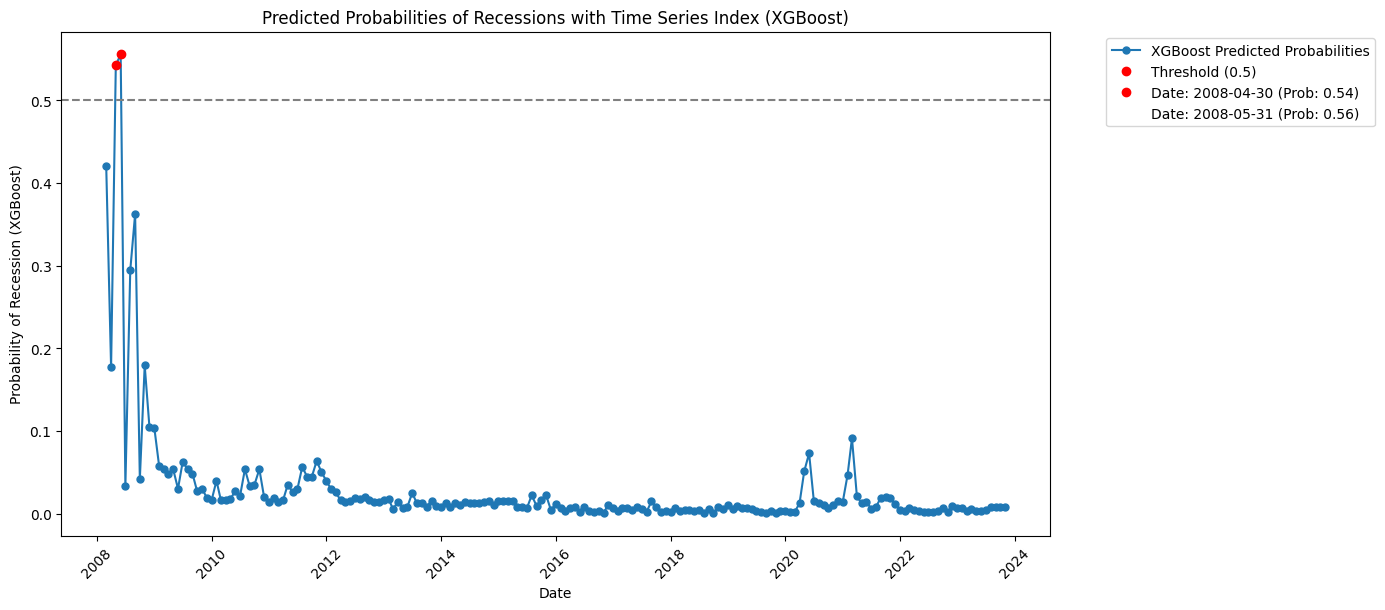

In [ ]:
import matplotlib.pyplot as plt

y_probs_xgb_full = model.predict_proba(X_test)[:, 1]
y_pred_xgb_full = (y_probs_xgb_full > 0.5).astype(int)

# Threshold for classification
threshold_xgb = 0.50

# Predicted classes for XGBoost
y_pred_xgb = (y_probs_xgb_full > threshold_xgb).astype(int)
correct_recession_indices_xgb = [i for i, (true, pred) in enumerate(zip(y_test, y_pred_xgb)) if true == 1 and pred == 1]
correctly_predicted_recessions_xgb = X_test.iloc[correct_recession_indices_xgb]

# Plotting all the XGBoost predicted probabilities with the time series index
plt.figure(figsize=(14, 6))
plt.plot(X_test.index, y_probs_xgb_full, '-o', label='XGBoost Predicted Probabilities', markersize=5)

# Highlighting the correctly predicted recessions using the time series index for XGBoost
for index_xgb in correctly_predicted_recessions_xgb.index:
    plt.plot(index_xgb, y_probs_xgb_full[X_test.index.get_loc(index_xgb)], 'ro')  # Using red circles to highlight

# Creating a list to hold custom legend entries for XGBoost
legend_entries_xgb = ['XGBoost Predicted Probabilities', f'Threshold ({threshold_xgb})']

# Adding dates where the probability is above the threshold to the custom legend for XGBoost
above_threshold_dates_xgb = X_test.index[y_probs_xgb_full > threshold_xgb]
for date_xgb in above_threshold_dates_xgb:
    prob_xgb = y_probs_xgb_full[X_test.index.get_loc(date_xgb)]
    label_xgb = f"Date: {date_xgb.strftime('%Y-%m-%d')} (Prob: {prob_xgb:.2f})"
    plt.plot([], [], ' ', label=label_xgb)  # Empty plot to add entries to the legend
    legend_entries_xgb.append(label_xgb)

plt.axhline(threshold_xgb, color='grey', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Probability of Recession (XGBoost)')
plt.title('Predicted Probabilities of Recessions with Time Series Index (XGBoost)')
plt.legend(legend_entries_xgb, loc="upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate the date labels for better visibility
plt.show()


In [ ]:
from sklearn.metrics import classification_report
train_size = int(len(X) * 0.70)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic_model = LogisticRegression(max_iter=1000)  # Increase max_iter
logistic_model.fit(X_train_scaled, y_train)

# Step 4: Model Evaluation
# Make predictions on the test set
y_pred = logistic_model.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
# Get the classification report as a string
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_report_str)

Accuracy: 0.9523809523809523
Confusion Matrix:
[[166   4]
 [  5  14]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       170
         1.0       0.78      0.74      0.76        19

    accuracy                           0.95       189
   macro avg       0.87      0.86      0.87       189
weighted avg       0.95      0.95      0.95       189



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform
import numpy as np

# Define the parameter grid
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': loguniform(1e-5, 1e5),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': np.arange(100, 1000, 100),
}

# Create a Logistic Regression model
logistic_model = LogisticRegression()

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    logistic_model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42, verbose=1
)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the RandomizedSearchCV on your data
random_search.fit(X_scaled, y)

# Print the best hyperparameters and the corresponding accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'C': 0.17846733763435624, 'max_iter': 600, 'penalty': 'l2', 'solver': 'sag'}
Best Accuracy: 0.8933968253968253


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
165 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise ValueError(
ValueError: Onl

In [ ]:
# Get the best hyperparameters from RandomizedSearchCV
best_params = random_search.best_params_

# Create a Logistic Regression model with the best hyperparameters
logistic_model = LogisticRegression(**best_params)

# Fit the model
logistic_model.fit(X_scaled, y)

# Evaluate the model as before
# Make predictions on the test set
y_pred = logistic_model.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_report)

Accuracy: 0.9894179894179894
Confusion Matrix:
[[169   1]
 [  1  18]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       170
         1.0       0.95      0.95      0.95        19

    accuracy                           0.99       189
   macro avg       0.97      0.97      0.97       189
weighted avg       0.99      0.99      0.99       189



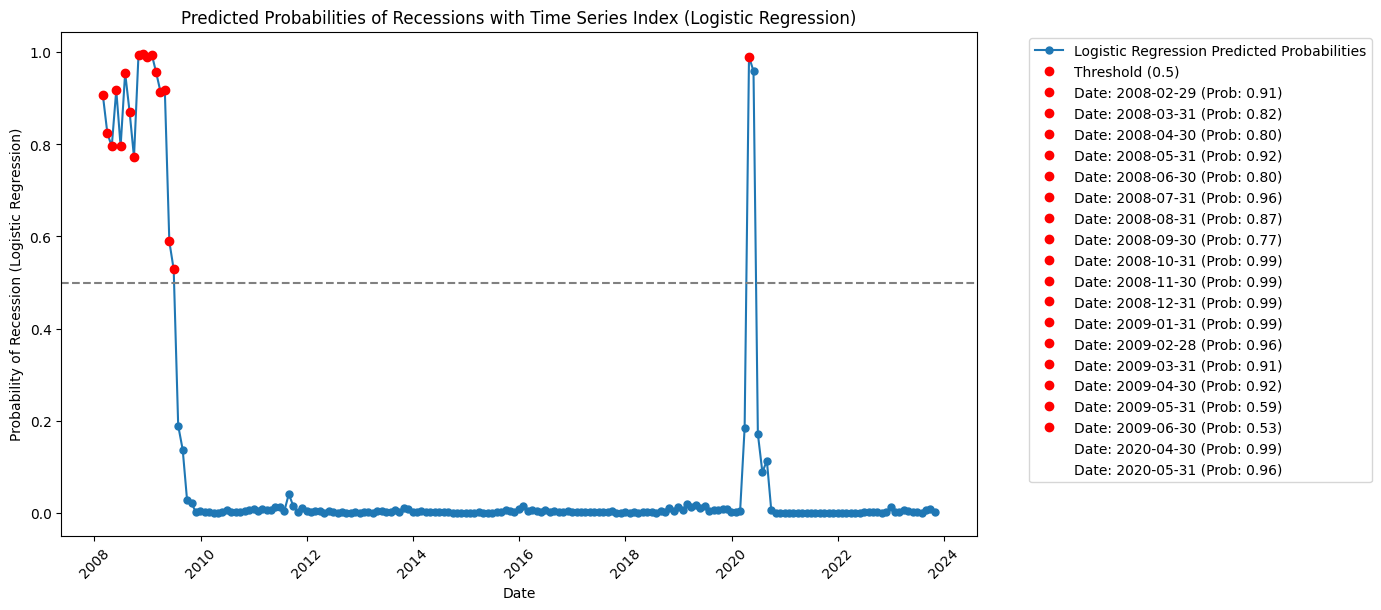

In [ ]:
import matplotlib.pyplot as plt

# Predicted probabilities for Logistic Regression
y_probs_logreg = logistic_model.predict_proba(X_test_scaled)[:, 1]
y_pred_logreg = (y_probs_logreg > 0.5).astype(int)

# Threshold for classification
threshold_logreg = 0.50

# Finding the indices of correctly predicted recessions using the time series index for Logistic Regression
correct_recession_indices_logreg = [i for i, (true, pred) in enumerate(zip(y_test, y_pred_logreg)) if true == 1 and pred == 1]
correctly_predicted_recessions_logreg = X_test.iloc[correct_recession_indices_logreg]

# Plotting all the Logistic Regression predicted probabilities with the time series index
plt.figure(figsize=(14, 6))
plt.plot(X_test.index, y_probs_logreg, '-o', label='Logistic Regression Predicted Probabilities', markersize=5)

# Highlighting the correctly predicted recessions using the time series index for Logistic Regression
for index_logreg in correctly_predicted_recessions_logreg.index:
    plt.plot(index_logreg, y_probs_logreg[X_test.index.get_loc(index_logreg)], 'ro')  # Using red circles to highlight

# Creating a list to hold custom legend entries for Logistic Regression
legend_entries_logreg = ['Logistic Regression Predicted Probabilities', f'Threshold ({threshold_logreg})']

# Adding dates where the probability is above the threshold to the custom legend for Logistic Regression
above_threshold_dates_logreg = X_test.index[y_probs_logreg > threshold_logreg]
for date_logreg in above_threshold_dates_logreg:
    prob_logreg = y_probs_logreg[X_test.index.get_loc(date_logreg)]
    label_logreg = f"Date: {date_logreg.strftime('%Y-%m-%d')} (Prob: {prob_logreg:.2f})"
    plt.plot([], [], ' ', label=label_logreg)  # Empty plot to add entries to the legend
    legend_entries_logreg.append(label_logreg)

plt.axhline(threshold_logreg, color='grey', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Probability of Recession (Logistic Regression)')
plt.title('Predicted Probabilities of Recessions with Time Series Index (Logistic Regression)')
plt.legend(legend_entries_logreg, loc="upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate the date labels for better visibility
plt.show()



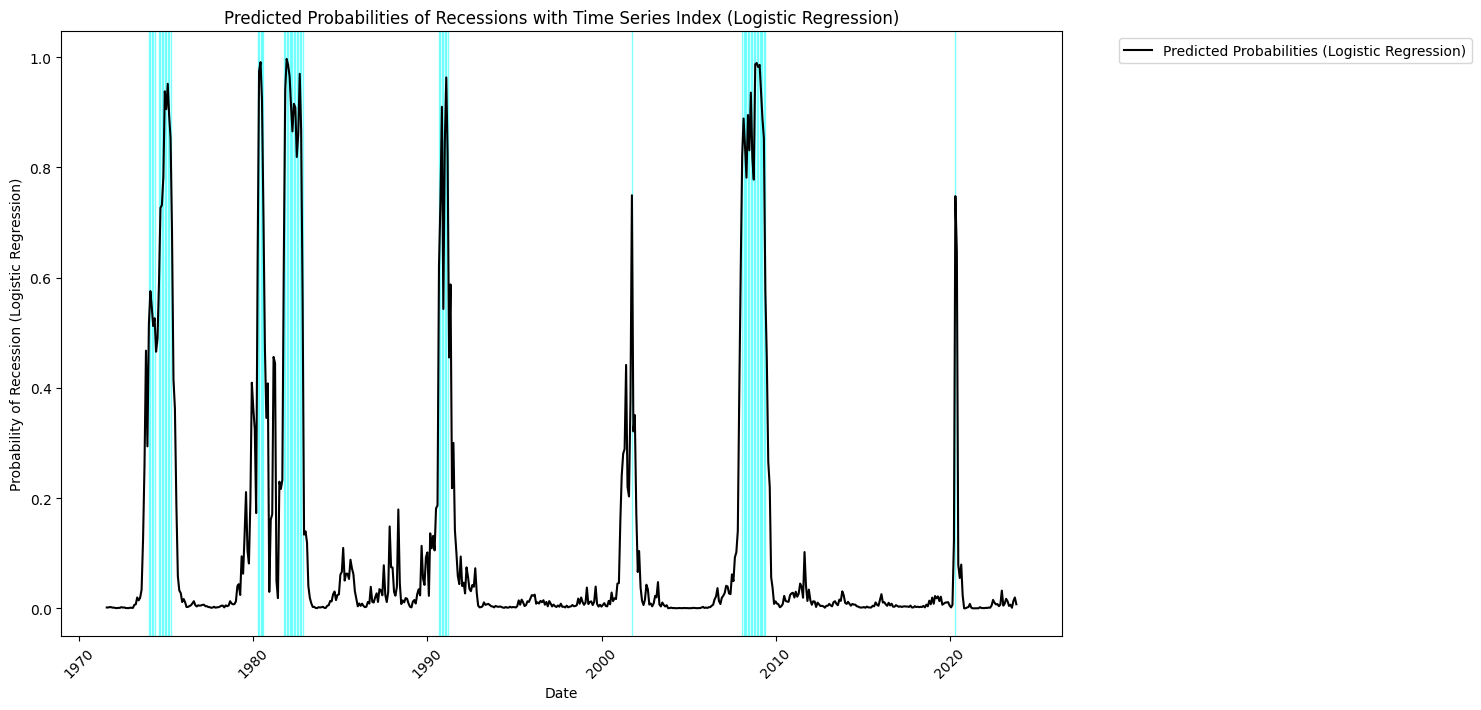

In [ ]:
# Predict probabilities for the entire dataset using Logistic Regression
y_probs_logreg_full = logistic_model.predict_proba(X_scaled)[:, 1]
y_pred_logreg_full = (y_probs_logreg_full > 0.5).astype(int)

plt.figure(figsize=(15, 7))

# Plotting the Predicted Probabilities for Logistic Regression
sns.lineplot(x=X.index, y=y_probs_logreg_full, color='black', label="Predicted Probabilities (Logistic Regression)")

# Highlight regions where the Logistic Regression model correctly predicted recessions
correct_recession_indices_logreg = X[(y == 1) & (y_pred_logreg_full == 1)].index
for start in correct_recession_indices_logreg:
    end = start  # As you're using monthly data, this will shade a single month
    plt.axvspan(start, end, color='cyan', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Probability of Recession (Logistic Regression)')
plt.title('Predicted Probabilities of Recessions with Time Series Index (Logistic Regression)')
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate the date labels for better visibility
plt.show()
